In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D

In [3]:
langevin = LangevinTripleWell1D(gamma=2.0)
#sample = langevin.sample(0, 2_000_000)

sample = np.load("sample.np",allow_pickle=True)

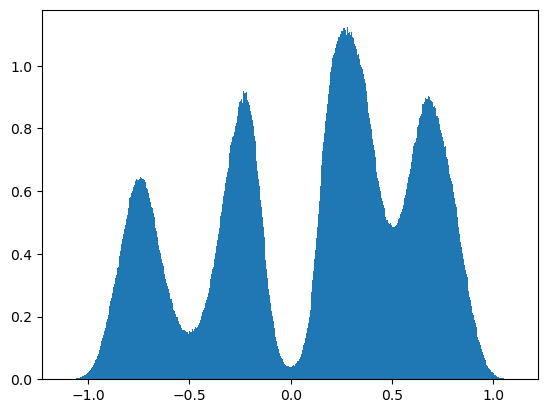

In [4]:
plt.hist(sample, bins=500, density=True);

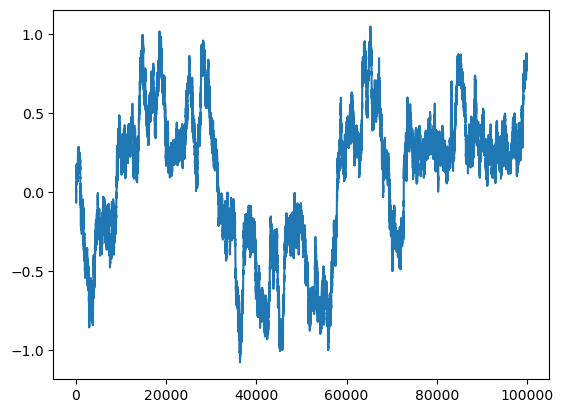

In [5]:
plt.plot(sample[:100_000])


In [25]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.models import kernel_generator
from kooplearn.data import traj_to_contexts
# 0.14 1e-1 2.8e-1
kernel = RBF(length_scale=np.array([0.14])) #0.3
model = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=4e-4,rank=3999 #6
                                   
                                   , tikhonov_reg=8e-1 #2.45e-1
                        )

In [26]:
test=sample[:2000_000:500]
train_data = traj_to_contexts(test)
forces = langevin.force_fn(test)
forces_train = traj_to_contexts(forces)
train_data.shape


(3999, 2, 1)

In [27]:
model = model.fit(train_data,forces=forces_train/2.0,friction=np.array([2/2.0])) #np.sqrt(2))


Fitted KernelInverseGenerator model. Lookback length set to 1


In [28]:
vals_gen,vecs_gen = model.eig(eval_right_on=train_data[:,:1, ...])


/home/tdevergne@iit.local/Documents/kooplearn/kooplearn/_src/operator_regression/dual.py:402: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/tdevergne@iit.local/Documents/kooplearn/kooplearn/_src/operator_regression/dual.py:407: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


In [29]:
print((4e-4-1/vals_gen))
#print(model.kernel_X)


[ 3.69926468e+13+0.00000000e+00j  3.70114169e+13+0.00000000e+00j
  3.69552419e+13+3.47831694e+12j ... -3.78576431e+00+0.00000000e+00j
 -6.23105624e-01+0.00000000e+00j -1.28398295e-02+0.00000000e+00j]


In [30]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    init_frames = contexts[:, :model.lookback_len, ...] # Everything in the lookback window is used for inference
    pred_frames = model.predict(init_frames) # Predicting the future frames
    true_frames = contexts[:, model.lookback_len:, ...].reshape(*pred_frames.shape) # The true frames are everything after the lookback length (i.e. the lookforward window)
    
    return mean_squared_error(true_frames, pred_frames)
prediction_error(model,train_data)

0.26177132804417175

###### 

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([], dtype=int64),)


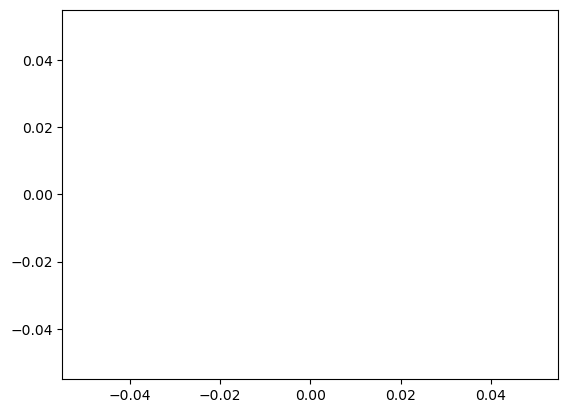

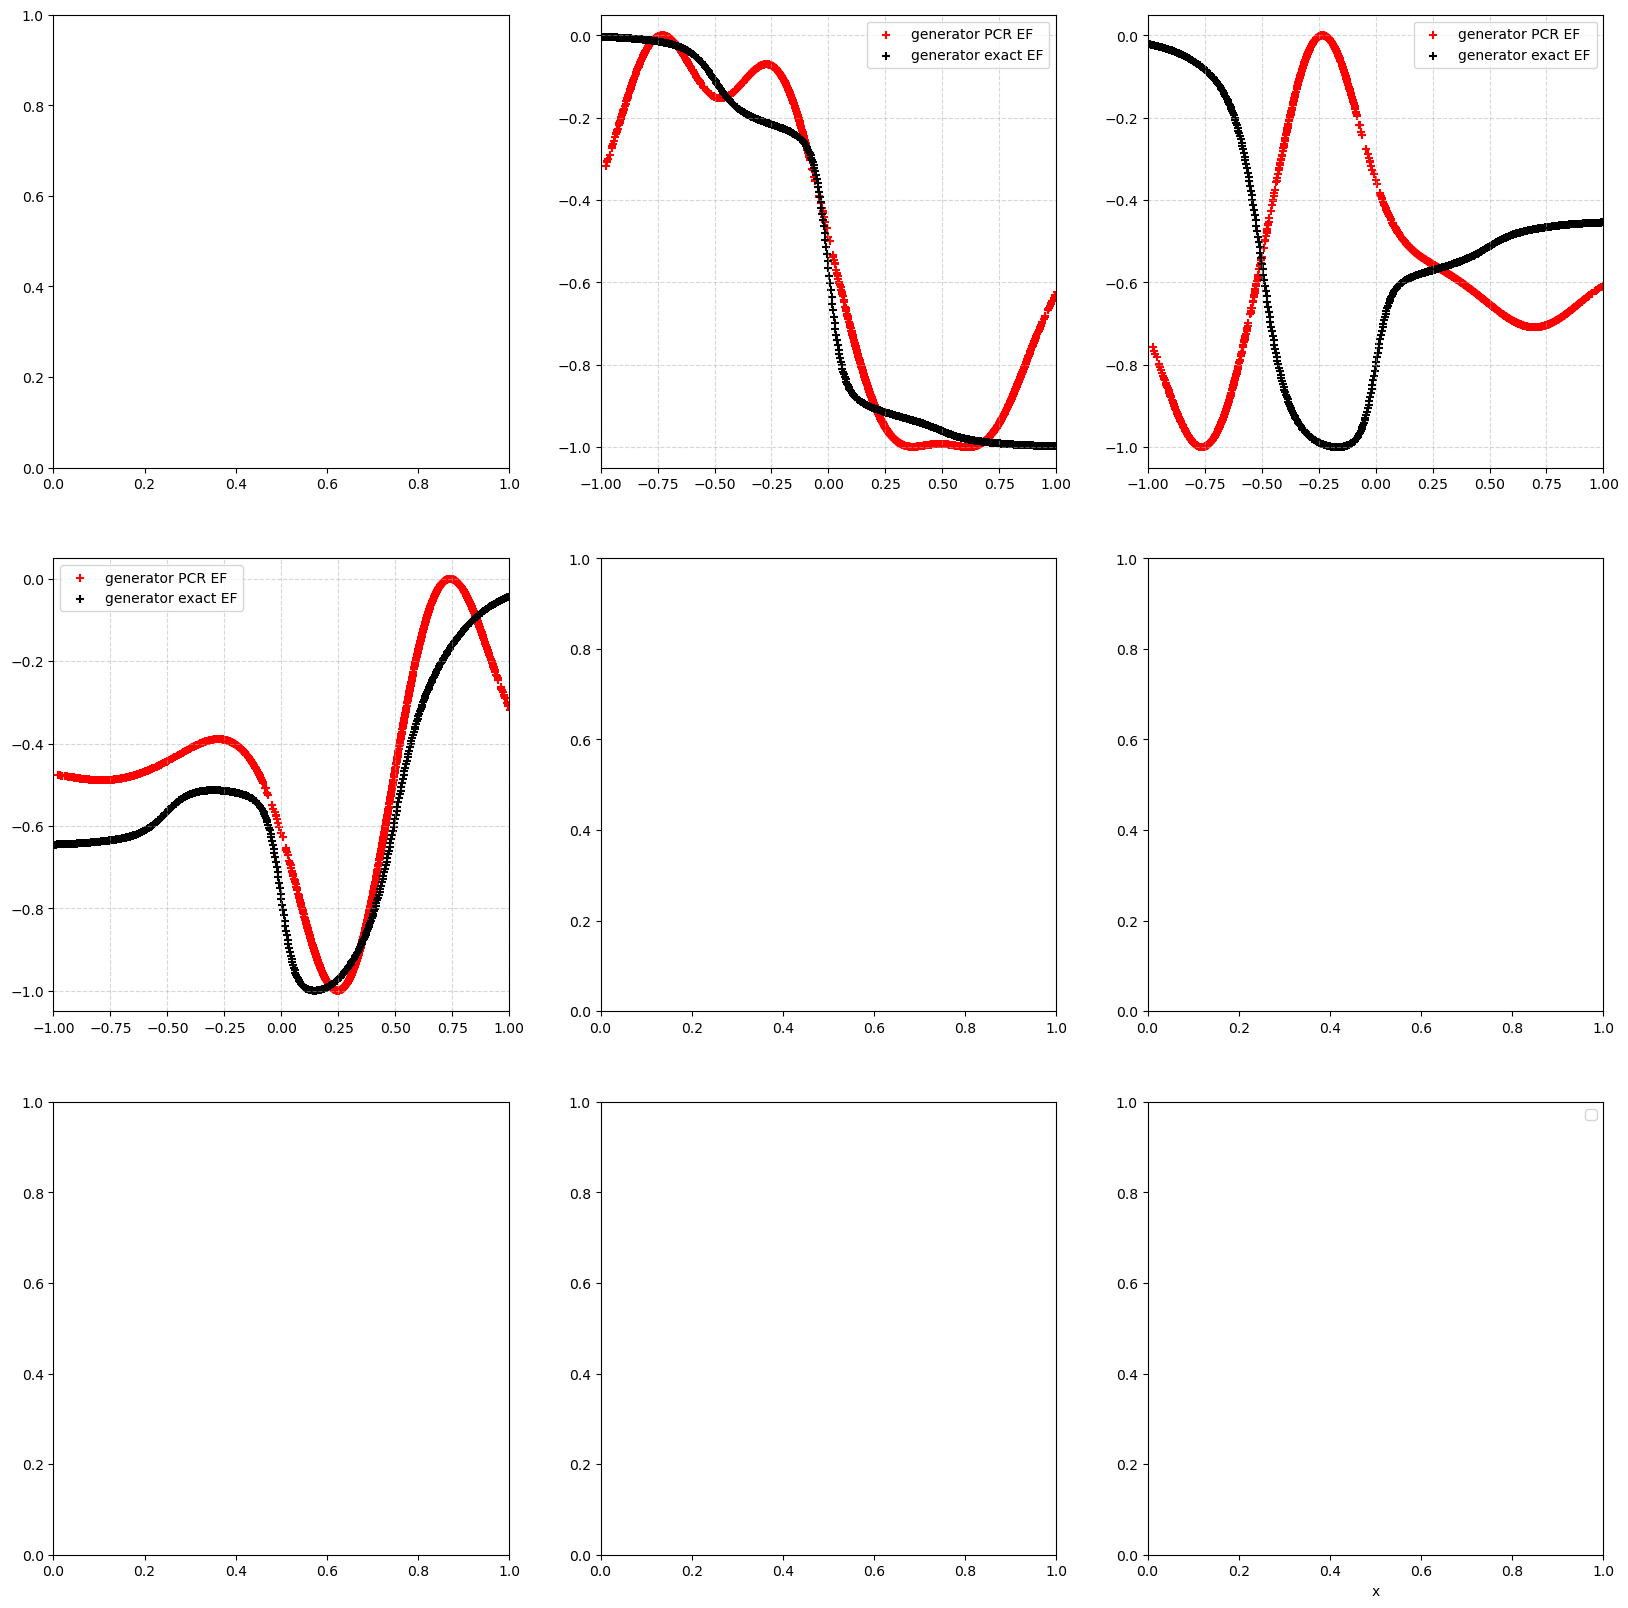

In [31]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt




solutions =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions.np",allow_pickle=True)
x_values  =np.load("/home/tdevergne@iit.local/Documents/centers.np",allow_pickle=True)


plt.plot()
num = 3
fig, axes = plt.subplots(num, num, figsize=(20, 20))
#values = np.where(np.logical_and(decomp.x>-1,decomp.x<1))[0]
print(np.where(vecs_gen[:,-1]==0))

new_0 = -(vecs_gen[:,-1]-vecs_gen[:,-1].min())/(vecs_gen[:,-1].min()-vecs_gen[:,-1].max())

for i in range(1,4):

    vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    new_gen = (vecs_gen[:,-i-1]-vecs_gen[:,-i-1].min())/(vecs_gen[:,-i-1].min()-vecs_gen[:,-i-1].max())
    new_sol = (solutions[:,i]-solutions[:,i].min())/(solutions[:,i].min()-solutions[:,i].max())
    if i ==1 :
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), -new_gen-1, marker="+", color='r',label="generator PCR EF")

    else:
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), new_gen, marker="+", color='r',label="generator PCR EF")
    axes[i//num, i%num].scatter(x_values,new_sol, marker="+", color='k', label="generator exact EF")
    
    axes[i//num, i%num].grid(True, linestyle='--', alpha=.5)
    axes[i//num, i%num].set_xlim(-1, 1)
    #axes[i//num, i%num].set_ylim(y_min, y_max)

    axes[i//num, i%num].legend()

plt.xlabel('x')
#plt.ylabel('')
plt.legend()
plt.show()

In [32]:
from scipy.sparse.linalg import LinearOperator
from scipy.linalg import lstsq
class CustomOperator(LinearOperator):
    def __init__(self, K, M, eta):
        self.K = K
        self.M = M
        self.eta = eta
        self.shape = K.shape
        self.dtype = K.dtype
    def matvec(self, v):
        # Perform the operation: eta*v - scipy.lstsq(K, M@v)
        lstsq_result = lstsq(self.K, self.M @ v)
        inter = self.eta * v - lstsq_result[0]
        solution = self.eta * inter  - self.M @ lstsq(self.K, v)[0]
        return solution

    def rmatvec(self, v):
    # Perform the adjoint operation: eta*v - scipy.lstsq(K.T, M.T @ v)
        lstsq_result = lstsq(self.K.T, self.M.T @ v)
        solution = self.eta * v - lstsq_result[0] - self.K.T @ lstsq(self.M.T, v)[0]
        return solution
K = np.array([[1, 0], [0, 1]])
M = np.array([[2, 1], [1, 2]])
eta = 0.5

# Define the right-hand side vector b
b = np.array([1, 2])

    

In [33]:
from scipy.sparse.linalg import cg
custom_op = CustomOperator(K, M, eta)

# Solve the linear system using conjugate gradient method
x, info = cg(custom_op, b)

print("Solution x:", x)
print("Information:", info)

Solution x: [ 0.04705882 -0.75294118]
Information: 0


/tmp/ipykernel_3601006/3459442635.py:2: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  custom_op = CustomOperator(K, M, eta)
